In [10]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 99 kB/s 
     |████████████████████████████████| 2.1 MB 47.4 MB/s 
     |████████████████████████████████| 1.8 MB 52.3 MB/s 


In [2]:
import math
import random
import argparse

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import Categorical
from collections import namedtuple

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display


In [3]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cpu


In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)  # as a ring buffer
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch)) # stack for each element
        ''' 
        the * serves as unpack: sum(a,b) <=> batch=(a,b), sum(*batch) ;
        zip: a=[1,2], b=[2,3], zip(a,b) => [(1, 2), (2, 3)] ;
        the map serves as mapping the function on each list element: map(square, [2,3]) => [4,9] ;
        np.stack((1,2)) => array([1, 2])
        '''
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)


In [5]:
class ContinuousActionLinearPolicy(object):
    def __init__(self, theta, state_dim, action_dim):
        assert len(theta) == (state_dim + 1) * action_dim
        self.W = theta[0 : state_dim * action_dim].reshape(state_dim, action_dim)
        self.b = theta[state_dim * action_dim : None].reshape(1, action_dim)
    def act(self, state):
        # a = state.dot(self.W) + self.b
        a = np.dot(state, self.W) + self.b
        return a
    def update(self, theta):
        self.W = theta[0 : state_dim * action_dim].reshape(state_dim, action_dim)
        self.b = theta[state_dim * action_dim : None].reshape(1, action_dim)

In [6]:
class CEM():
    ''' 
    cross-entropy method, as optimization of the action policy 
    '''
    def __init__(self, theta_dim, ini_mean_scale=0.0, ini_std_scale=1.0):
        self.theta_dim = theta_dim
        self.initialize(ini_mean_scale=ini_mean_scale, ini_std_scale=ini_std_scale)

    def initialize(self, ini_mean_scale=0.0, ini_std_scale=1.0):
        self.mean = ini_mean_scale*np.ones(self.theta_dim)
        self.std = ini_std_scale*np.ones(self.theta_dim)
        
    def sample(self):
        # theta = self.mean + np.random.randn(self.theta_dim) * self.std
        theta = self.mean + np.random.normal(size=self.theta_dim) * self.std
        return theta

    def sample_multi(self, n):
        theta_list=[]
        for i in range(n):
            theta_list.append(self.sample())
        return np.array(theta_list)


    def update(self, selected_samples):
        self.mean = np.mean(selected_samples, axis = 0)
        # print('mean: ', self.mean)
        self.std = np.std(selected_samples, axis = 0)  # plus the entropy offset, or else easily get 0 std
        # print('std: ', self.std)

        return self.mean, self.std

In [7]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, init_w=3e-3):
        super(QNetwork, self).__init__()
        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1) # the dim 0 is number of samples
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [30]:
class QT_Opt():
    def __init__(self, replay_buffer, hidden_dim, q_lr=3e-4, cem_update_itr=2, select_num=6, num_samples=64):
        self.num_samples = num_samples
        self.select_num = select_num
        self.cem_update_itr = cem_update_itr
        self.replay_buffer = replay_buffer
        self.qnet = QNetwork(state_dim+action_dim, hidden_dim).to(device) # gpu
        self.target_qnet1 = QNetwork(state_dim+action_dim, hidden_dim).to(device)
        self.target_qnet2 = QNetwork(state_dim+action_dim, hidden_dim).to(device)
        self.cem = CEM(theta_dim = action_dim)  # cross-entropy method for updating

        self.q_optimizer = optim.Adam(self.qnet.parameters(), lr=q_lr)
        self.step_cnt = 0

    def update(self, batch_size, gamma=0.9, soft_tau=1e-2, update_delay=100):
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        self.step_cnt+=1

        
        state_      = torch.FloatTensor(state).to(device)
        next_state_ = torch.FloatTensor(next_state).to(device)
        action     = torch.FloatTensor(action).to(device)
        reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)  # reward is single value, unsqueeze() to add one dim to be [reward] at the sample dim;
        done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

        predict_q = self.qnet(state_, action) # predicted Q(s,a) value

        # get argmax_a' from the CEM for the target Q(s', a')
        new_next_action = []
        for i in range(batch_size):      # batch of states, use them one by one, to prevent the lack of memory
            new_next_action.append(self.cem_optimal_action(next_state[i]))
        new_next_action=torch.FloatTensor(new_next_action).to(device)

        target_q_min = torch.min(self.target_qnet1(next_state_, new_next_action), self.target_qnet2(next_state_, new_next_action))
        target_q = reward + (1-done)*gamma*target_q_min

        q_loss = ((predict_q - target_q.detach())**2).mean()  # MSE loss, note that original paper uses cross-entropy loss
        print(q_loss)
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # update the target nets, according to original paper:
        # one with Polyak averaging, another with lagged/delayed update
        self.target_qnet1=self.target_soft_update(self.qnet, self.target_qnet1, soft_tau)
        self.target_qnet2=self.target_delayed_update(self.qnet, self.target_qnet2, update_delay)
    


    def cem_optimal_action(self, state):
        ''' evaluate action wrt Q(s,a) to select the optimal using CEM '''
        cuda_states = torch.FloatTensor(np.vstack([state]*self.num_samples)).to(device)
        self.cem.initialize() # every time use a new cem, cem is only for deriving the argmax_a'
        for itr in range(self.cem_update_itr):
            actions = self.cem.sample_multi(self.num_samples)
            q_values = self.target_qnet1(cuda_states, torch.FloatTensor(actions).to(device)).detach().cpu().numpy().reshape(-1) # 2 dim to 1 dim
            max_idx=q_values.argsort()[-1]  # select one maximal q
            idx = q_values.argsort()[-int(self.select_num):]  # select top maximum q
            selected_actions = actions[idx]
            _,_=self.cem.update(selected_actions)
        optimal_action = actions[max_idx]
        return optimal_action
 

    def target_soft_update(self, net, target_net, soft_tau):
        ''' Soft update the target net '''
        for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(  # copy data value into target parameters
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

        return target_net

    def target_delayed_update(self, net, target_net, update_delay):
        ''' delayed update the target net '''
        if self.step_cnt%update_delay == 0:
            for target_param, param in zip(target_net.parameters(), net.parameters()):
                target_param.data.copy_(  # copy data value into target parameters
                    param.data 
                )

        return target_net





    def train(self):

      # hyper-parameters
        max_episodes  = 100
        max_steps   = 20  # Pendulum needs 150 steps per episode to learn well, cannot handle 20
        frame_idx   = 0
        episode_rewards = []

        for i_episode in range (max_episodes):
            
            if ENV == 'Bipedal':
                state =  env.reset()
            episode_reward = 0

            for step in range(max_steps):
                # action = qt_opt.policy.act(state)  
                action = qt_opt.cem_optimal_action(state)
                # print(action)
                if ENV ==  'Bipedal':
                    next_state, reward, done, _ = env.step(action) 
                    #env.render()
                episode_reward += reward
                replay_buffer.push(state, action, reward, next_state, done)
                state = next_state

            if len(replay_buffer) > batch_size:
                qt_opt.update(batch_size)
                qt_opt.save_model(model_path)

            episode_rewards.append(episode_reward)
            
            if i_episode% 10==0:
                qt_opt.plot(episode_rewards)
                
            print('Episode: {}  | Reward:  {}'.format(i_episode, episode_reward))




    def test(self,model_path):

        qt_opt.load_model(model_path)
        # hyper-parameters
        max_episodes  = 100
        max_steps   = 20   # Pendulum needs 150 steps per episode to learn well, cannot handle 20
        frame_idx   = 0
        episode_rewards = []

        for i_episode in range (max_episodes):
            
            if ENV == 'Bipedal':
                state =  env.reset()
            episode_reward = 0

            for step in range(max_steps):
                # action = qt_opt.policy.act(state)  
                action = qt_opt.cem_optimal_action(state)
                if ENV ==  'Bipedal':
                    next_state, reward, done, _ = env.step(action)  
                    #env.render()               
                episode_reward += reward
                state = next_state

            episode_rewards.append(episode_reward)
            # plot(episode_rewards)
            print('Episode: {}  | Reward:  {}'.format(i_episode, episode_reward))







    def save_model(self, path):
        torch.save(self.qnet.state_dict(), path)
        torch.save(self.target_qnet1.state_dict(), path)
        torch.save(self.target_qnet2.state_dict(), path)







    def load_model(self, path):
        self.qnet.load_state_dict(torch.load(path))
        self.target_qnet1.load_state_dict(torch.load(path))
        self.target_qnet2.load_state_dict(torch.load(path))
        self.qnet.eval()
        self.target_qnet1.eval()
        self.target_qnet2.eval()






    def plot(aelf,rewards):
        clear_output(True)
        plt.figure(figsize=(20,5))
        # plt.subplot(131)
        plt.plot(rewards)
        plt.savefig('qt_opt_v3.png')
        # plt.show()

Episode: 90  | Reward:  -10.257865339767722
tensor(0.0143, grad_fn=<MeanBackward0>)
Episode: 91  | Reward:  -9.8654672148174
tensor(0.0215, grad_fn=<MeanBackward0>)
Episode: 92  | Reward:  -8.225677077571682
tensor(0.0149, grad_fn=<MeanBackward0>)
Episode: 93  | Reward:  -7.756357599785423
tensor(0.0173, grad_fn=<MeanBackward0>)
Episode: 94  | Reward:  -8.690385521856525
tensor(0.0172, grad_fn=<MeanBackward0>)
Episode: 95  | Reward:  -9.520163690555849
tensor(0.0153, grad_fn=<MeanBackward0>)
Episode: 96  | Reward:  -9.15189696793017
tensor(0.0179, grad_fn=<MeanBackward0>)
Episode: 97  | Reward:  -9.472850237130471
tensor(0.0163, grad_fn=<MeanBackward0>)
Episode: 98  | Reward:  -8.948234790812332
tensor(0.0138, grad_fn=<MeanBackward0>)
Episode: 99  | Reward:  -8.077951535506092


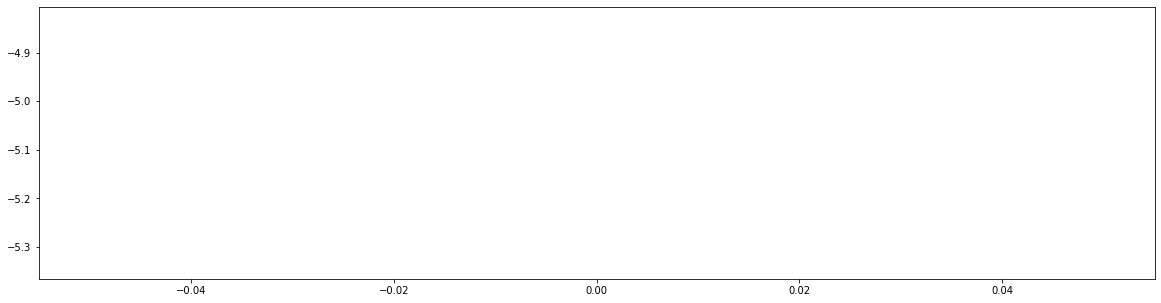

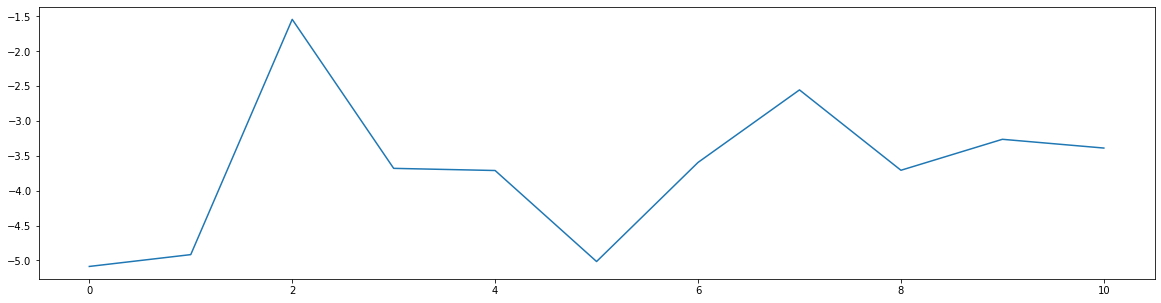

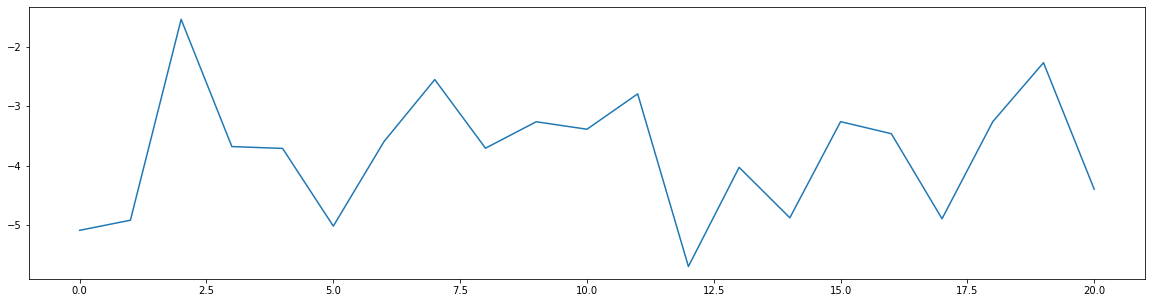

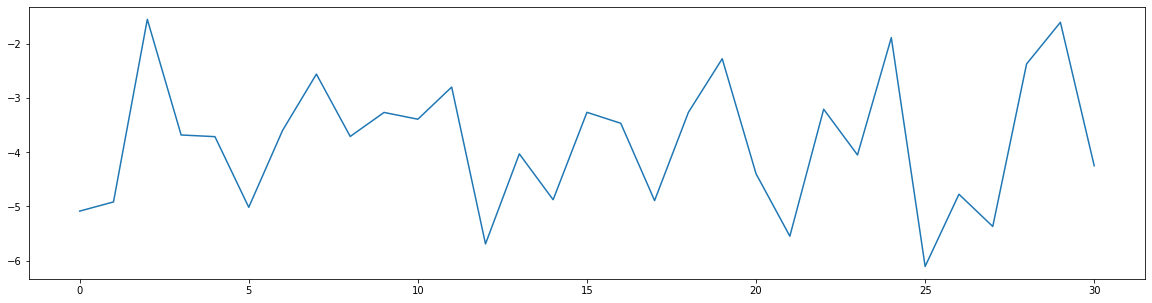

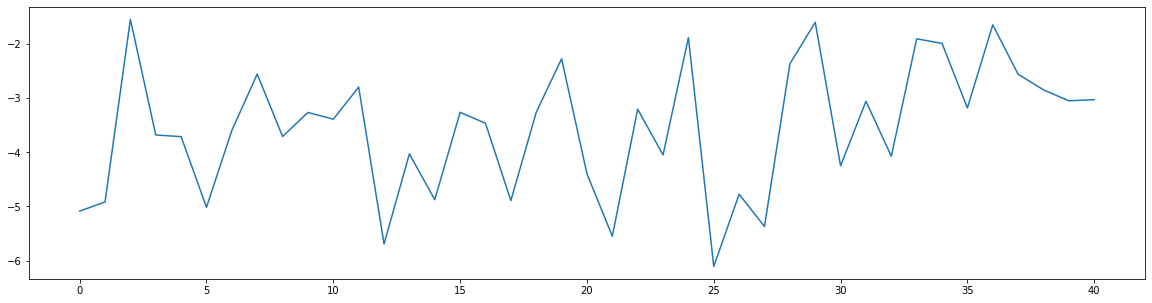

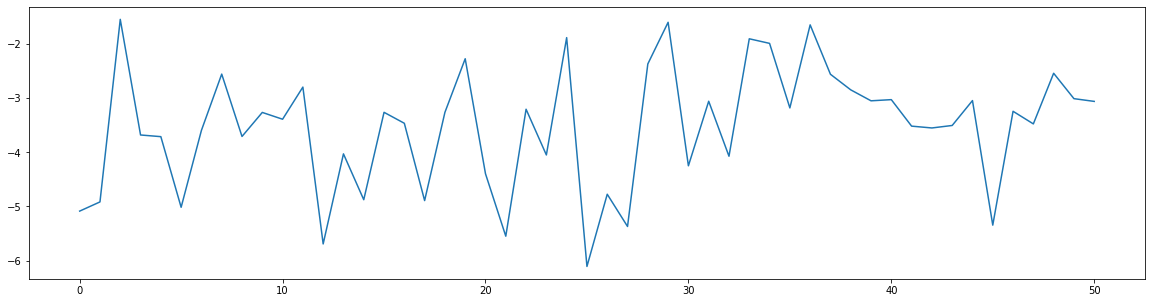

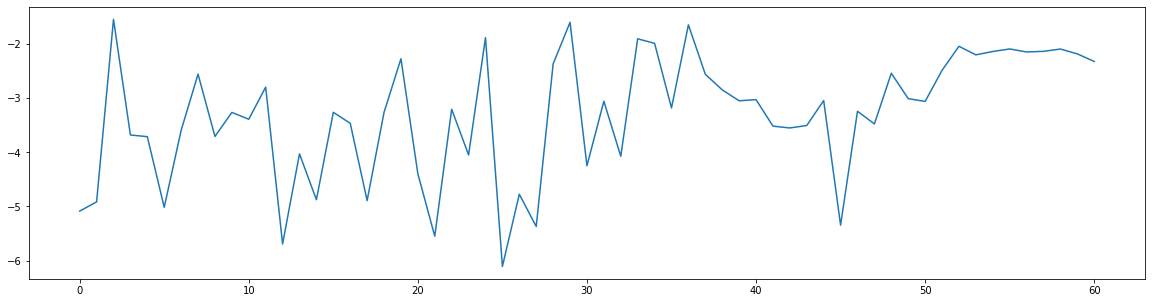

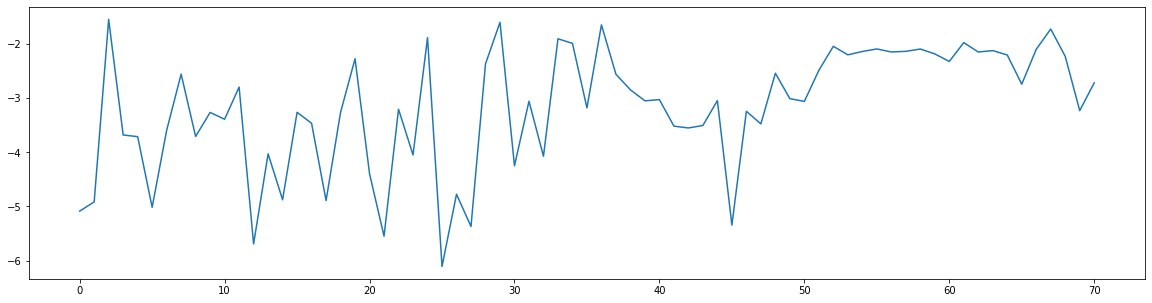

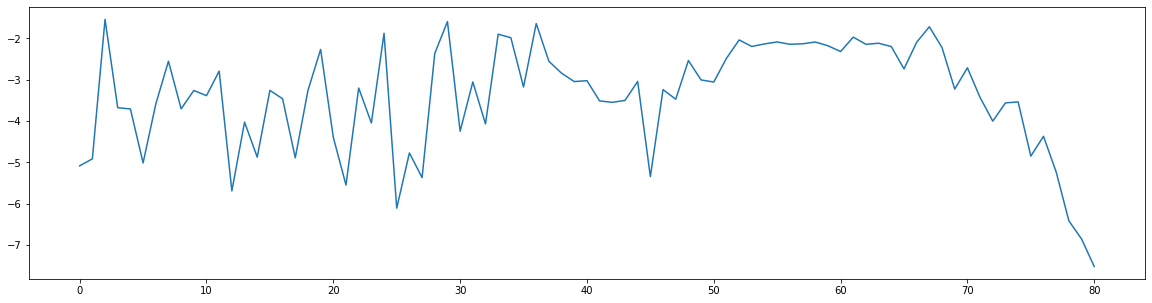

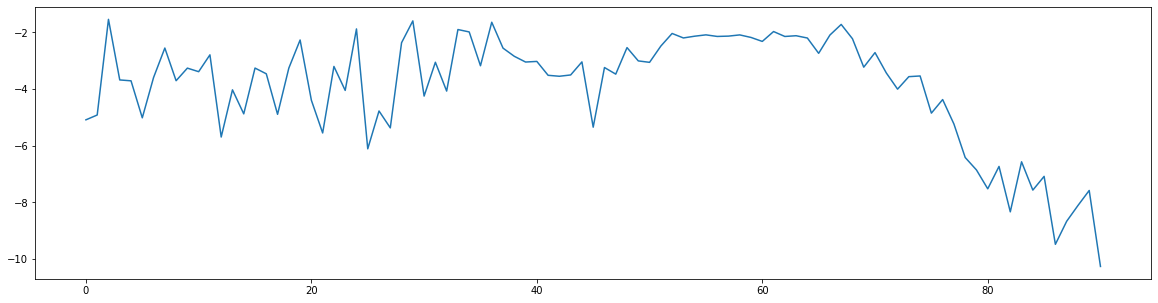

In [31]:
ENV = ['Bipedal'][0]
for e in ENV:
    if ENV == 'Bipedal':
        env = gym.make("BipedalWalker-v3")
        action_dim = env.action_space.shape[0]
        state_dim  = env.observation_space.shape[0]
        action_range=1.


hidden_dim = 512
batch_size=100
model_path = '/content/drive/MyDrive/Colab_data/QT_OPT/model_3'

replay_buffer_size = 5e5
replay_buffer = ReplayBuffer(replay_buffer_size)

qt_opt = QT_Opt(replay_buffer, hidden_dim)
qt_opt.train()
    
 

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''   if args.train:
        # hyper-parameters
        max_episodes  = 2000
        max_steps   = 20  # Pendulum needs 150 steps per episode to learn well, cannot handle 20
        frame_idx   = 0
        episode_rewards = []

        for i_episode in range (max_episodes):
            
            if ENV == 'Bipedal':
                state =  env.reset()
            episode_reward = 0

            for step in range(max_steps):
                # action = qt_opt.policy.act(state)  
                action = qt_opt.cem_optimal_action(state)
                if ENV ==  'Bipedal':
                    next_state, reward, done, _ = env.step(action) 
                    env.render()
                episode_reward += reward
                replay_buffer.push(state, action, reward, next_state, done)
                state = next_state

            if len(replay_buffer) > batch_size:
                qt_opt.update(batch_size)
                qt_opt.save_model(model_path)

            episode_rewards.append(episode_reward)
            
            if i_episode% 10==0:
                qt_opt.plot(episode_rewards)
                
            print('Episode: {}  | Reward:  {}'.format(i_episode, episode_reward)) 
    
    if args.test:
        qt_opt.load_model(model_path)
        # hyper-parameters
        max_episodes  = 2
        max_steps   = 20   # Pendulum needs 150 steps per episode to learn well, cannot handle 20
        frame_idx   = 0
        episode_rewards = []

        for i_episode in range (max_episodes):
            
            if ENV == 'Bipedal':
                state =  env.reset()
            episode_reward = 0

            for step in range(max_steps):
                # action = qt_opt.policy.act(state)  
                action = qt_opt.cem_optimal_action(state)
                if ENV ==  'Bipedal':
                    next_state, reward, done, _ = env.step(action)  
                    env.render()               
                episode_reward += reward
                state = next_state

            episode_rewards.append(episode_reward)
            # plot(episode_rewards)
            print('Episode: {}  | Reward:  {}'.format(i_episode, episode_reward)) '''